# Decoding Board from Data

In [514]:
#necessary imports
import pandas
import numpy as np
import tensorflow.keras as keras
from keras.models import Model
from keras.layers import Dense, Input
from IPython.display import display
import sympy as sp
sp.init_printing(use_latex = True)
import math

import matplotlib.pyplot as plt
%matplotlib inline

#retrieve vector data from gamestate
inputGamestate = np.array(pandas.read_table("nineFullData(2)_Validated.txt", delim_whitespace = True, header = None))

#Decoding Board From Data
board_size = 9 * 9
board_length = int(math.sqrt(board_size))
boardState = np.zeros((len(inputGamestate), (board_size + 1)))

In [515]:
whoseTurn = inputGamestate[:, board_size*3 + 3]

In [516]:
whoseTurn

array([-1, -1,  1, ..., -1,  1, -1])

In [517]:
boardState.shape #Number of board states present in the data/size of board

In [518]:
#Encoding board states to 1D array per data entry

index_of_board = 0
for row in inputGamestate:
    index_of_token = 0
    for item in row:
        if index_of_token < board_size*3:
            tile = inputGamestate[index_of_board][index_of_token:index_of_token + 3]
            if(tile[2] == 1):
                boardState[index_of_board][int(index_of_token/3)] = 0 #Tile is empty
            elif(tile[1] == 1):
                boardState[index_of_board][int(index_of_token/3)] = -1 #Black occupies this tile
            elif(tile[0] == 1):
                boardState[index_of_board][int(index_of_token/3)] = 1 #White occupies this tile
            index_of_token+=3
    boardState[index_of_board][board_size] = whoseTurn[index_of_board]
    index_of_board+=1

In [519]:
boardState[:4] #Examples of board changing with moves that are made

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0., -1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0., -1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.

# Data Categorization and Assignment

In [521]:
X = boardState[:, 0:82]

train_data = X.shape[0]

#Coordinate of move made to achieve board state (bottom left of the board being 0, 0)
#coordinate = inputGamestate[:, 243:245]

#Legality checker for the move
#legal = inputGamestate[:, 245]

#Black or white to move from this position(-1 or 1 respectively)
whoseTurn = inputGamestate[:, 246]

#Who won from this position (-1 or 1 respectively, 0 for play continues)
#whoWon = inputGamestate[:, 247]

#Move to be made from this position
playersMove = inputGamestate[:, 248]

#Input
#X = inputGamestate[:, :248]

#Creating 81 categories based on every spot on the board, 1 representing the move to be made
Y = keras.utils.to_categorical(playersMove, len(np.unique(playersMove)))

training_samples = int(0.9 * train_data)
X_train, X_test = X[:training_samples], X[training_samples:]
Y_train, Y_test = Y[:training_samples], Y[training_samples:]

In [522]:
boardState

array([[ 0.,  0.,  0., ...,  0.,  0., -1.],
       [ 0.,  0.,  0., ...,  0.,  0., -1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       ...,
       [ 0.,  1., -1., ...,  1.,  1., -1.],
       [ 0.,  1., -1., ...,  1.,  1.,  1.],
       [-1.,  1., -1., ...,  1.,  1., -1.]])

In [523]:
X[0].shape

In [524]:
Y.shape

# Building the Model

Model: "sequential_80"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_315 (Dense)            (None, 82)                6806      
_________________________________________________________________
reshape_35 (Reshape)         (None, 82, 1)             0         
_________________________________________________________________
zero_padding1d_5 (ZeroPaddin (None, 100, 1)            0         
_________________________________________________________________
reshape_36 (Reshape)         (None, 10, 10, 1)         0         
_________________________________________________________________
conv2d_132 (Conv2D)          (None, 10, 10, 48)        480       
_________________________________________________________________
zero_padding2d_110 (ZeroPadd (None, 10, 16, 54)        0         
_________________________________________________________________
conv2d_133 (Conv2D)          (None, 10, 16, 48)      

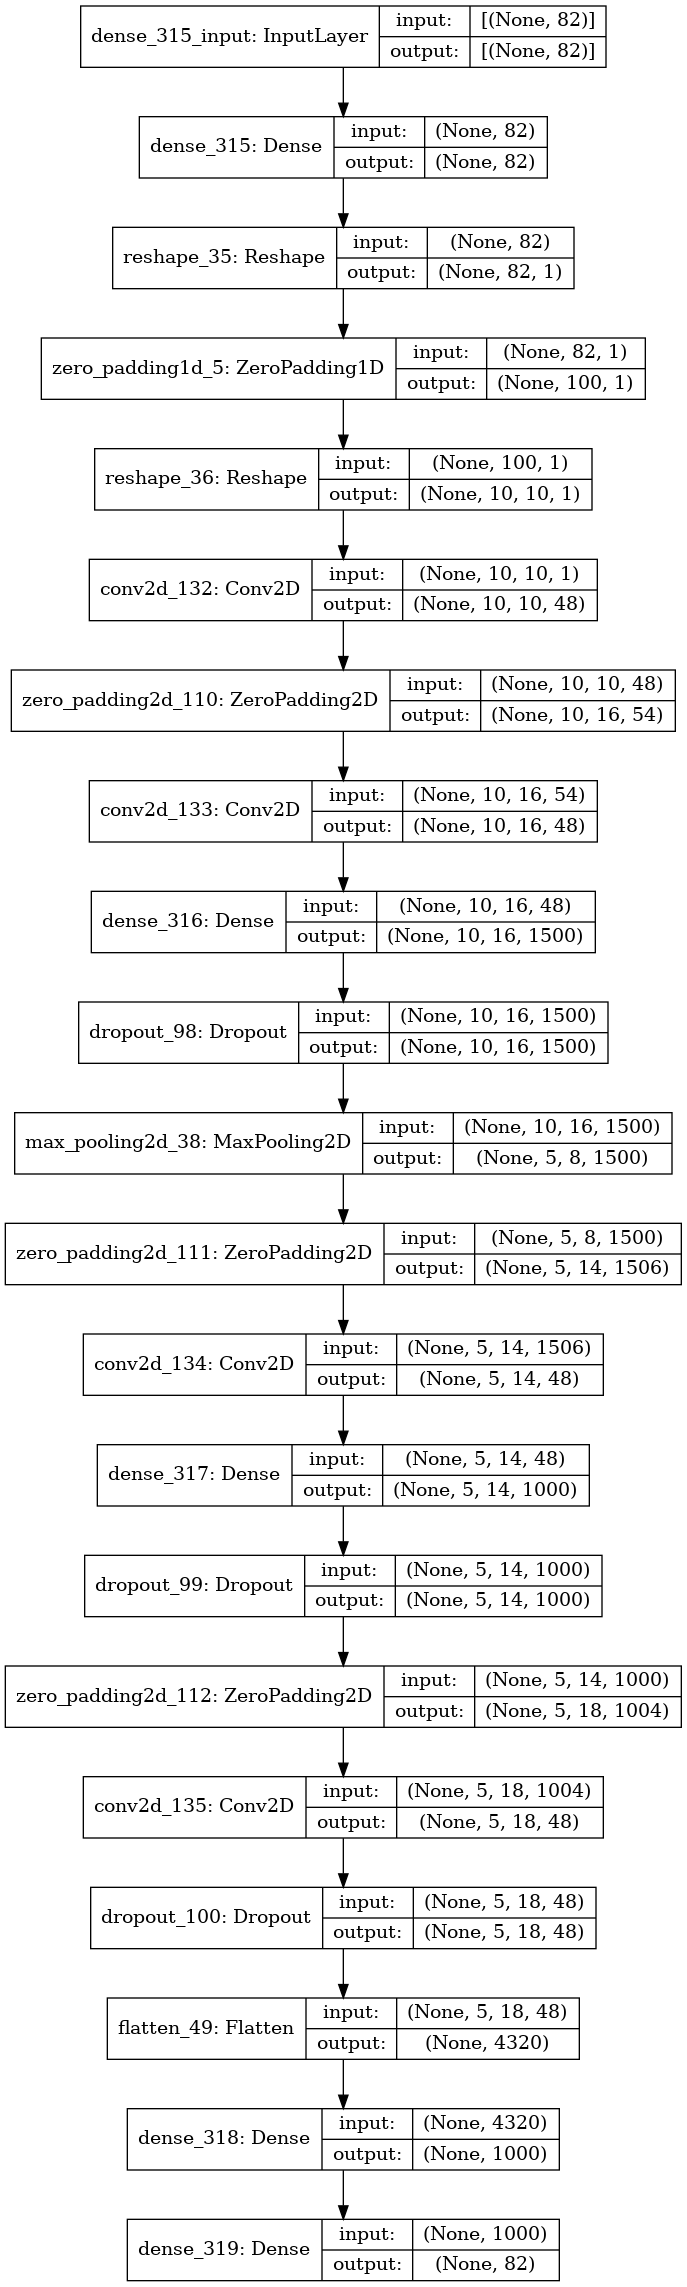

In [546]:
#defining input shape (board state)
#input_size = X.shape[1]

input_shape = X[0].shape
input_shape_whoseTurn = whoseTurn[0].shape

#defining output shape 
#output_size = Y.shape[1]
model = keras.models.Sequential()
model.add(keras.layers.Dense(82, input_shape = input_shape))
model.add(keras.layers.Reshape((82, 1)))
model.add(keras.layers.ZeroPadding1D(padding = 9))
model.add(keras.layers.Reshape((10, 10, 1)))
model.add(keras.layers.Conv2D(48, kernel_size = (3, 3), activation = 'relu', padding = 'same', input_shape = input_shape))
model.add(keras.layers.ZeroPadding2D(padding = 3, input_shape = input_shape, data_format = 'channels_first'))
model.add(keras.layers.Conv2D(48, kernel_size = (7, 7), activation = 'relu', padding = 'same', input_shape = input_shape))
model.add(keras.layers.Dense(1500, activation = 'relu'))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.MaxPooling2D(pool_size = (2, 2)))
model.add(keras.layers.ZeroPadding2D(padding = 3, input_shape = input_shape, data_format = 'channels_first'))
model.add(keras.layers.Conv2D(48, kernel_size = (5, 5), activation = 'relu', padding = 'same'))
model.add(keras.layers.Dense(1500, activation = 'relu'))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.ZeroPadding2D(padding = 2, input_shape = input_shape, data_format = 'channels_first'))
model.add(keras.layers.Conv2D(48, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1500, activation = 'relu'))
model.add(keras.layers.Dense(Y.shape[1], activation = 'softmax'))

#hidden1 = keras.layers.Dense(1000, activation = 'relu')(conv2D_1)
#hidden2 = keras.layers.Dense(1000, activation = 'relu')(hidden1)
#hidden3 = keras.layers.Dense(1000, activation = 'relu')(hidden2)
#drop1 = keras.layers.Dropout(0.2)(hidden3)
#hidden4 = keras.layers.Dense(1000, activation = 'relu')(drop1)
#hidden5 = keras.layers.Dense(1000, activation = 'relu')(hidden4)
#output = keras.layers.Dense(82, activation = 'softmax')(hidden5)
#model = Model(inputs = conv2D_1, outputs = output)

model.compile(loss=keras.losses.CategoricalCrossentropy(), optimizer = keras.optimizers.Adam(), metrics = [keras.metrics.CategoricalAccuracy()])
model.summary()
keras.utils.plot_model(model, show_shapes = True, expand_nested = True, show_layer_names = True)

#0 if the game ends
#1 - 81
#row major order from top left, bottom right is 81

In [548]:
#Example taking output (pretraining)
print(boardState[4].shape)
model_input = np.array([boardState[1]])
model.predict(model_input)

(82,)


array([[0.01219807, 0.01218694, 0.01218514, 0.01219484, 0.01218914,
        0.01219241, 0.0122034 , 0.01220158, 0.01220345, 0.01219817,
        0.0121966 , 0.01219308, 0.01220007, 0.01219056, 0.01219723,
        0.01219353, 0.01219632, 0.01219886, 0.01220115, 0.01218866,
        0.01220077, 0.01219499, 0.01219157, 0.01219357, 0.01219734,
        0.01219462, 0.01219553, 0.01219496, 0.01219718, 0.01219426,
        0.01219164, 0.0121881 , 0.01219162, 0.0121979 , 0.01219006,
        0.01218988, 0.01220141, 0.01219341, 0.01219208, 0.01219739,
        0.01219429, 0.01219782, 0.012199  , 0.01220153, 0.01219163,
        0.01220211, 0.01219175, 0.01219454, 0.0121886 , 0.01219981,
        0.01219073, 0.01219585, 0.01219767, 0.01219637, 0.01219923,
        0.01219222, 0.01219301, 0.01219448, 0.01219181, 0.01219296,
        0.01219529, 0.01220307, 0.01219548, 0.01218996, 0.01220071,
        0.01219497, 0.01219517, 0.01219992, 0.01219874, 0.01219446,
        0.01220013, 0.01219952, 0.0121872 , 0.01

# Training

In [ ]:
#Train the model
history = model.fit(X_train, Y_train, batch_size = 128, epochs = 10, verbose = 1, validation_data = (X_test, Y_test))

Epoch 1/10
   3/2828 [..............................] - ETA: 1:40:56 - loss: 4.4079 - categorical_accuracy: 0.0191

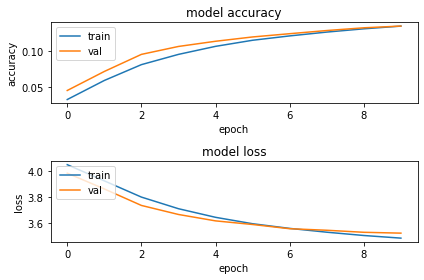

In [488]:
plt.figure(1)

plt.subplot(211)
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss') 

plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.tight_layout()
plt.show()

In [489]:
#Train the model
history = model.fit(X_train, Y_train, batch_size = 128, epochs = 10, verbose = 1, validation_data = (X_test, Y_test))

Epoch 1/10
2828/2828 [==============================] - 2837s 1s/step - loss: 3.4613 - categorical_accuracy: 0.1389 - val_loss: 3.5128 - val_categorical_accuracy: 0.1360
Epoch 2/10
2828/2828 [==============================] - 2842s 1s/step - loss: 3.4436 - categorical_accuracy: 0.1414 - val_loss: 3.5099 - val_categorical_accuracy: 0.1382
Epoch 3/10
2828/2828 [==============================] - 3276s 1s/step - loss: 3.4323 - categorical_accuracy: 0.1434 - val_loss: 3.4926 - val_categorical_accuracy: 0.1396
Epoch 4/10
2828/2828 [==============================] - 4211s 1s/step - loss: 3.4193 - categorical_accuracy: 0.1459 - val_loss: 3.4842 - val_categorical_accuracy: 0.1426
Epoch 5/10
2828/2828 [==============================] - 4210s 1s/step - loss: 3.4093 - categorical_accuracy: 0.1479 - val_loss: 3.4907 - val_categorical_accuracy: 0.1418
Epoch 6/10
2828/2828 [==============================] - 4213s 1s/step - loss: 3.3987 - categorical_accuracy: 0.1498 - val_loss: 3.4869 - val_categoric

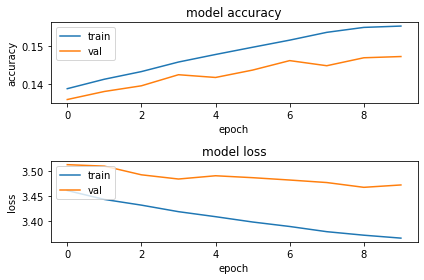

In [490]:
plt.figure(1)

plt.subplot(211)
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss') 

plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.tight_layout()
plt.show()

In [493]:
model.save_weights('weights_15_1D_Convolution.h5')

In [494]:
history = model.fit(X_train, Y_train, batch_size = 128, epochs = 10, verbose = 1, validation_data = (X_test, Y_test))

Epoch 1/10
2563/2828 [==========================>...] - ETA: 5:40 - loss: 3.3563 - categorical_accuracy: 0.1571

KeyboardInterrupt: 

In [239]:
model.save_weights('weights.h5')